In [1]:
!which python

/home/paperspace/anaconda3/envs/fastai/bin/python


In [2]:
import sys
sys.path.append('..')

In [3]:
import enum
import math
import pdb
import platform
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook
from albumentations import Compose, HorizontalFlip

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TransformsTrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox import utils
from ssdmultibox.plotting import *

import matplotlib.pyplot as plt
plt.ion()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
device

device(type='cuda', index=0)

In [5]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [6]:
model = SSDModel().to(device)

In [7]:
LR = 1e-3
SSD_LOSS_ALPHA = 100

criterion = SSDLoss(alpha=SSD_LOSS_ALPHA)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
current_time = time.time()

In [8]:
train_dataset = TransformsTrainPascalFlatDataset(
    transform=Compose([HorizontalFlip(p=0.5)],
                       bbox_params={'format': 'coco', 'label_fields': ['category_id']}))

len(train_dataset)

2501

In [9]:
NUM_WORKERS = utils.get_cpu_count()
BATCH = 16
SHUFFLE = True
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TransformsTrainPascalFlatDataset at 0x7f9f5c8ee128>,
 'batch_size': 16,
 'num_workers': 8,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f9eb3edada0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f9eb3edadd8>,
 '_DataLoader__initialized': True}

In [16]:
EPOCHS = 3

for epoch in range(EPOCHS):
    scheduler.step()
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

pos_loss: 246.9476 neg_hard_mining_loss: 417.5457
n: 66.0 bbs_loss: 113.9199 cats_loss: 664.4934
epoch: 0 step: 0 loss: 11.7941 time: 98.2159
pos_loss: 483.7926 neg_hard_mining_loss: 1092.7942
n: 113.0 bbs_loss: 79.4212 cats_loss: 1576.5867
pos_loss: 337.8306 neg_hard_mining_loss: 333.6286
n: 80.0 bbs_loss: 129.1078 cats_loss: 671.4592
pos_loss: 376.1298 neg_hard_mining_loss: 541.5476
n: 88.0 bbs_loss: 167.9679 cats_loss: 917.6775
pos_loss: 356.6141 neg_hard_mining_loss: 670.2825
n: 101.0 bbs_loss: 133.1135 cats_loss: 1026.8967
pos_loss: 399.6281 neg_hard_mining_loss: 550.6991
n: 106.0 bbs_loss: 155.8945 cats_loss: 950.3273
epoch: 0 step: 5 loss: 10.4361 time: 8.5558
pos_loss: 635.3048 neg_hard_mining_loss: 890.7024
n: 159.0 bbs_loss: 332.0298 cats_loss: 1526.0073
pos_loss: 403.3550 neg_hard_mining_loss: 930.7867
n: 105.0 bbs_loss: 170.4663 cats_loss: 1334.1417
pos_loss: 546.2579 neg_hard_mining_loss: 791.0454
n: 136.0 bbs_loss: 159.1637 cats_loss: 1337.3036
pos_loss: 519.8447 neg_hard

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9ecdbe1f98>>
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/paperspace/anacond

pos_loss: 551.9976 neg_hard_mining_loss: 44.5319
n: 168.0 bbs_loss: 271.2123 cats_loss: 596.5296
epoch: 0 step: 75 loss: 5.1651 time: 8.6808
pos_loss: 560.1528 neg_hard_mining_loss: 2.8181
n: 148.0 bbs_loss: 232.0315 cats_loss: 562.9708
pos_loss: 533.6333 neg_hard_mining_loss: 22.0156
n: 139.0 bbs_loss: 209.0289 cats_loss: 555.6489
pos_loss: 642.6016 neg_hard_mining_loss: 116.4397
n: 174.0 bbs_loss: 226.7514 cats_loss: 759.0413
pos_loss: 297.9652 neg_hard_mining_loss: 4.4331
n: 90.0 bbs_loss: 177.6247 cats_loss: 302.3983
pos_loss: 589.1354 neg_hard_mining_loss: 197.0224
n: 157.0 bbs_loss: 250.4561 cats_loss: 786.1577
epoch: 0 step: 80 loss: 6.6026 time: 8.6408
pos_loss: 548.8469 neg_hard_mining_loss: 6.4527
n: 145.0 bbs_loss: 231.7505 cats_loss: 555.2996
pos_loss: 435.2252 neg_hard_mining_loss: 3.9982
n: 118.0 bbs_loss: 158.4406 cats_loss: 439.2235
pos_loss: 712.3687 neg_hard_mining_loss: 95.4396
n: 183.0 bbs_loss: 182.3180 cats_loss: 807.8084
pos_loss: 460.8366 neg_hard_mining_loss: 2

pos_loss: 475.3588 neg_hard_mining_loss: 7.5855
n: 129.0 bbs_loss: 134.4795 cats_loss: 482.9443
pos_loss: 519.9951 neg_hard_mining_loss: 12.3357
n: 153.0 bbs_loss: 186.8130 cats_loss: 532.3307
pos_loss: 358.3922 neg_hard_mining_loss: 1.5175
n: 105.0 bbs_loss: 213.4312 cats_loss: 359.9096
epoch: 0 step: 155 loss: 5.4604 time: 8.7216
pos_loss: 347.9520 neg_hard_mining_loss: 6.5473
n: 103.0 bbs_loss: 133.8050 cats_loss: 354.4993



pos_loss: 408.4098 neg_hard_mining_loss: 1.4208
n: 101.0 bbs_loss: 296.1099 cats_loss: 409.8306
epoch: 1 step: 0 loss: 6.9895 time: 3.9633
pos_loss: 339.3754 neg_hard_mining_loss: 0.6990
n: 98.0 bbs_loss: 246.9610 cats_loss: 340.0744
pos_loss: 554.0967 neg_hard_mining_loss: 19.3918
n: 160.0 bbs_loss: 218.9868 cats_loss: 573.4884
pos_loss: 522.0126 neg_hard_mining_loss: 0.9499
n: 121.0 bbs_loss: 93.2763 cats_loss: 522.9624
pos_loss: 462.0383 neg_hard_mining_loss: 1.9890
n: 110.0 bbs_loss: 112.3189 cats_loss: 464.0272
pos_loss: 571.3570 neg_hard_mining_loss: 5.1181
n: 139.0 bbs_loss: 258.2679 cats_loss: 576.4751
epoch: 1 step: 5 loss: 6.0053 time: 8.8996
pos_loss: 545.5587 neg_hard_mining_loss: 2.1439
n: 132.0 bbs_loss: 173.7556 cats_loss: 547.7028
pos_loss: 479.4126 neg_hard_mining_loss: 2.3403
n: 137.0 bbs_loss: 201.9564 cats_loss: 481.7529
pos_loss: 514.9870 neg_hard_mining_loss: 2.4386
n: 143.0 bbs_loss: 110.3639 cats_loss: 517.4257
pos_loss: 339.5951 neg_hard_mining_loss: 3.2406
n: 

pos_loss: 445.8179 neg_hard_mining_loss: 0.3768
n: 128.0 bbs_loss: 157.8743 cats_loss: 446.1947
pos_loss: 546.2208 neg_hard_mining_loss: 3.2122
n: 150.0 bbs_loss: 126.3399 cats_loss: 549.4330
epoch: 1 step: 80 loss: 4.5052 time: 8.6031
pos_loss: 340.4431 neg_hard_mining_loss: 1.4910
n: 96.0 bbs_loss: 234.5176 cats_loss: 341.9341
pos_loss: 483.3077 neg_hard_mining_loss: 1.2716
n: 119.0 bbs_loss: 114.1420 cats_loss: 484.5792
pos_loss: 328.0291 neg_hard_mining_loss: 1.9248
n: 109.0 bbs_loss: 167.8257 cats_loss: 329.9538
pos_loss: 394.4037 neg_hard_mining_loss: 2.0467
n: 102.0 bbs_loss: 122.2422 cats_loss: 396.4503
pos_loss: 435.5388 neg_hard_mining_loss: 3.1548
n: 127.0 bbs_loss: 236.6939 cats_loss: 438.6935
epoch: 1 step: 85 loss: 5.3180 time: 8.6724
pos_loss: 391.6824 neg_hard_mining_loss: 4.3734
n: 114.0 bbs_loss: 215.7356 cats_loss: 396.0559
pos_loss: 470.4788 neg_hard_mining_loss: 2.9000
n: 125.0 bbs_loss: 234.2425 cats_loss: 473.3787
pos_loss: 299.3989 neg_hard_mining_loss: 0.5151
n

pos_loss: 285.6304 neg_hard_mining_loss: 0.1471
n: 74.0 bbs_loss: 119.2051 cats_loss: 285.7775
epoch: 2 step: 0 loss: 5.4727 time: 4.1914
pos_loss: 445.8970 neg_hard_mining_loss: 1.3865
n: 121.0 bbs_loss: 140.2577 cats_loss: 447.2835
pos_loss: 408.9880 neg_hard_mining_loss: 1.8789
n: 102.0 bbs_loss: 235.4810 cats_loss: 410.8669
pos_loss: 375.8226 neg_hard_mining_loss: 3.5998
n: 115.0 bbs_loss: 260.2725 cats_loss: 379.4224
pos_loss: 350.8919 neg_hard_mining_loss: 0.9666
n: 93.0 bbs_loss: 111.6353 cats_loss: 351.8585
pos_loss: 451.3577 neg_hard_mining_loss: 0.9268
n: 112.0 bbs_loss: 160.8387 cats_loss: 452.2845
epoch: 2 step: 5 loss: 5.4743 time: 9.0004
pos_loss: 634.4319 neg_hard_mining_loss: 48.0860
n: 176.0 bbs_loss: 281.6781 cats_loss: 682.5179
pos_loss: 434.8822 neg_hard_mining_loss: 3.1370
n: 128.0 bbs_loss: 166.5396 cats_loss: 438.0192
pos_loss: 512.0312 neg_hard_mining_loss: 1.2193
n: 144.0 bbs_loss: 241.9681 cats_loss: 513.2506
pos_loss: 529.8019 neg_hard_mining_loss: 42.4699
n:

pos_loss: 553.5686 neg_hard_mining_loss: 3.2495
n: 147.0 bbs_loss: 91.7738 cats_loss: 556.8181
pos_loss: 524.8292 neg_hard_mining_loss: 1.6401
n: 149.0 bbs_loss: 186.1115 cats_loss: 526.4694
epoch: 2 step: 80 loss: 4.7824 time: 8.6498
pos_loss: 567.2395 neg_hard_mining_loss: 0.7745
n: 138.0 bbs_loss: 241.0706 cats_loss: 568.0139
pos_loss: 411.6902 neg_hard_mining_loss: 1.0810
n: 112.0 bbs_loss: 91.0115 cats_loss: 412.7712
pos_loss: 728.2404 neg_hard_mining_loss: 44.0980
n: 170.0 bbs_loss: 211.5426 cats_loss: 772.3383
pos_loss: 314.8259 neg_hard_mining_loss: 0.3271
n: 104.0 bbs_loss: 182.7683 cats_loss: 315.1530
pos_loss: 348.8609 neg_hard_mining_loss: 2.3751
n: 111.0 bbs_loss: 233.3427 cats_loss: 351.2361
epoch: 2 step: 85 loss: 5.2665 time: 8.6927
pos_loss: 508.9969 neg_hard_mining_loss: 2.2555
n: 135.0 bbs_loss: 197.8694 cats_loss: 511.2524
pos_loss: 304.8530 neg_hard_mining_loss: 0.7569
n: 93.0 bbs_loss: 161.4342 cats_loss: 305.6099
pos_loss: 403.3897 neg_hard_mining_loss: 4.3282
n:

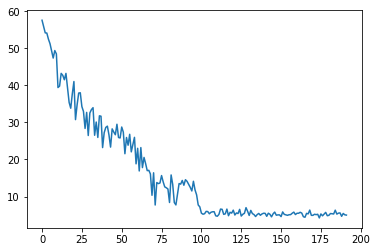

In [17]:
plt.plot(losses['total'])

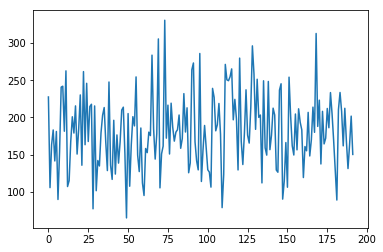

In [18]:
plt.plot(losses['loc'])

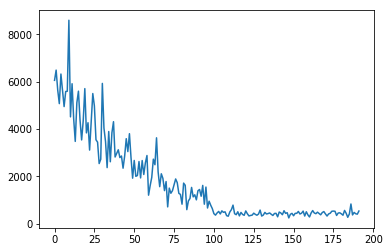

In [19]:
plt.plot(losses['conf'])

In [20]:
utils.save_model(model, dirname='../model_checkpoints/')

model saved at: ../model_checkpoints/model-2018-12-20T09:19:07.cpkt


In [15]:
# model.unfreeze()